# Predict Oil Palm Plantation from Satellite Images

Train a model that takes as input a satellite image and outputs a prediction of how likely it is that the image contains an oil palm plantation. The model is used to make prediction on the unlabeled images in test set. This is a [WiDS Datathon 2019](https://www.kaggle.com/c/widsdatathon2019) in Kaggle. 

The training set images are stored in folder `train_images` and the test images are stored in folder `leaderboard_test_data`, and `leaderboard_holdout_data`. The label is in the file `traininglabels.csv` with label 1 means the image has oil palm. 

In [1]:
#setup the notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.greedy=True

import sys
import feather
from pathlib import Path
from glob import glob
sys.path.append(r'C:\Users\Benny\fastai\old')

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is FC06-B52C

 Directory of C:\Users\Benny\Documents\Fern\widsdatathon2019

02/27/2019  10:28 AM    <DIR>          .
02/27/2019  10:28 AM    <DIR>          ..
02/27/2019  10:19 AM    <DIR>          .ipynb_checkpoints
02/20/2019  09:27 PM        46,258,105 leaderboard_holdout_data.zip
02/27/2019  10:24 AM    <DIR>          leaderboard_test_data
02/20/2019  09:27 PM        94,811,591 leaderboard_test_data.zip
02/27/2019  10:28 AM             1,933 oil_palm_images.ipynb
02/20/2019  09:27 PM           137,236 SampleSubmission.csv
02/20/2019  09:27 PM           362,925 traininglabels.csv
02/25/2019  01:01 PM    <DIR>          train_images
               5 File(s)    141,571,790 bytes
               5 Dir(s)  23,443,681,280 bytes free


In [3]:
trn_path = 'train_images/'
filenames = glob(trn_path+'*.jpg')
len(filenames)

15244

In [12]:
trn_df = pd.read_csv('traininglabels.csv') 
trn_df.columns

Index(['image_id', 'has_oilpalm', 'score'], dtype='object')

In [15]:
trn_df_mod = trn_df.drop('score', axis=1)
trn_df_mod['image_id'] = trn_path + trn_df['image_id'].values

In [17]:
trn_df_mod.to_csv('trainlabels_mod.csv',index=False)

In [13]:
trn_df_mod = pd.read_csv('trainlabels_mod.csv')

In [21]:
filenames = trn_df_mod['image_id'].values

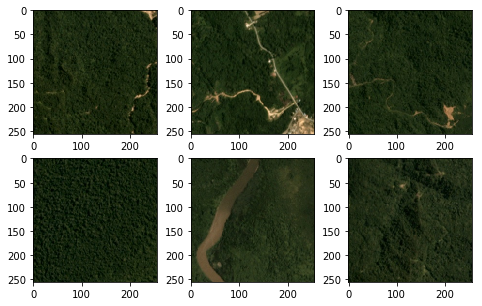

In [48]:
plt.figure(figsize=(8,5))

for i in range(1,7):
    ax = plt.subplot(2,3,i)
    ax = plt.imshow(plt.imread(filenames[i]))   

In [54]:
trn_df_mod.has_oilpalm.value_counts()

0    14302
1      942
Name: has_oilpalm, dtype: int64

In [4]:
#allodate some data into a test set 
test_idxs = get_cv_idxs(len(trn_df), val_pct=0.1, seed=52)
test = trn_df.iloc[test_idxs]
y_test = test['has_oilpalm'].values

len(y_test)

1524

In [182]:
#put internal test images into a test folder 
import shutil

t_filenames = test['image_id'].values
for file in t_filenames:
    shutil.copy(trn_path+file,'test/'+file) 

In [73]:
df = trn_df_mod.drop(test_idxs , axis=0)
df['has_oilpalm'].value_counts()

0    12880
1      840
Name: has_oilpalm, dtype: int64

In [74]:
len(df)
df.to_csv('train_val.csv',index=False)

In [100]:
# get baseline accuracy 
from sklearn.metrics import accuracy_score, log_loss

In [102]:
y_true = trn_df_mod['has_oilpalm'].values
y_pred = np.zeros(len(y_true))
print('baseline accuracy =', accuracy_score(y_true, y_pred))
print('baseline loss =', log_loss(y_true, y_pred))

baseline accuracy = 0.9382051954867489
baseline loss = 2.1343169354503986


In summary, we have 15244 training images, and will allocate 1524(10%) as a test and as 2744 validation(20% of the remaining), leaving 10976 for the training set. There are two hold out sets: leader_board_test folder has 4356 files and learder_board_holdout_data has 2178 files. The internal test images are copied to folder test, and the train image list is in the 'train_val.csv'.

About 6% of the images have oil palm. The training set should have about 658 images with oil palm. The images are 256 x 256 pixels and have 3 channels. Baseline: if a model predicts all images to have no oil palm will get 94% accuracy and 2 log_loss. 

Leaderboard test images are in the same folder as the internal test images. 

## Unbalance Training Data

This dataset has unbalance dataset, only 6% of images have oil palm. To solve this, I will add augmented images this class in the training folder. 

1. Define functions to generate augmented images: 

    * `rotate_cv` return a rotated image. I use this to create 7 more images each with multiple of 45 deg rotation.
    * `stretch_cv` return 3 images with a 1.01 horizontal or vertical zoom or both.  
    * I will get (7+3) x 672 = 6720 images
    * Randomly select half of these images to put into either `lighting` or `blur`. This procedure should give me 
    * At the end, I will have ((7+3) x 672 + 3360 about 10080 images or more (if perform randomness two times will generate more images)
    * These functions are from transform.py in fast.ai library
  
2. Randomly shuffle the images and include 8000 images into a training label csv file with these filenames and label 1. Note that the images are in a separate folder)

In [88]:
df = pd.read_csv('train_val.csv')
idxs = get_cv_idxs(len(df), val_pct=0.2, seed=52)
df_trn = df.drop(idxs, axis=0)
df_trn['has_oilpalm'].value_counts()
oilimage = df_trn[df_trn['has_oilpalm']==1]['image_id'].values

In [5]:
len(oilimage), oilimage[:5]

(672,
 array(['train_images/img_001132017.jpg', 'train_images/img_001712017.jpg', 'train_images/img_002012017.jpg',
        'train_images/img_002402017.jpg', 'train_images/img_002722017.jpg'], dtype=object))

In [37]:
# copy training images labeled with_oilpalm into another folder
import shutil

for file in oilimage:
    shutil.copy(file,'train_has_oil/'+file.split('/')[1]) 

In [2]:
oilimages = glob('train_has_oil/*.jpg')

I am going to pick one image and illustrate the effect of each augmented functions: rotate_cv, blur, stretch_cv, blur.

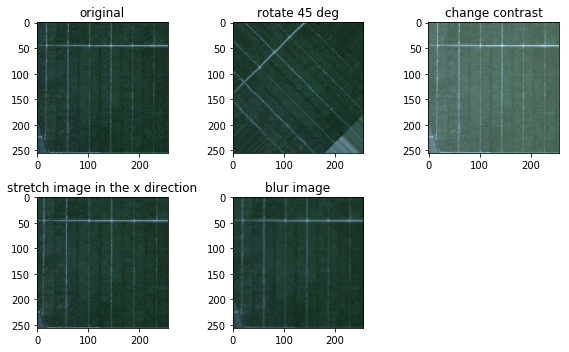

In [27]:
img = cv2.imread(oilimages[0])
roimg = rotate_cv(img, 45)
lightimg = lighting(img)
stretch_x = stretch_cv(img, 0.05, 0)
blurimg = blur(img)

plt.figure(figsize=(8,5))
ax = plt.subplot(2,3,1)
ax.imshow(img)
ax.set_title('original')

ax = plt.subplot(2,3,2)
ax.imshow(roimg)
ax.set_title('rotate 45 deg');

ax = plt.subplot(2,3,3)
ax.imshow(lightimg)
ax.set_title('change contrast')

ax = plt.subplot(2,3,4)
ax.imshow(stretch_x)
ax.set_title('stretch image in the x direction')

ax = plt.subplot(2,3,5)
ax.imshow(blurimg)
ax.set_title('blur image')
plt.tight_layout()

Create another function `gen_rot` that generate 7 rotated images at different multiple of 45 angles. This function also save the rotated images and return list of the rotated image filenames. 

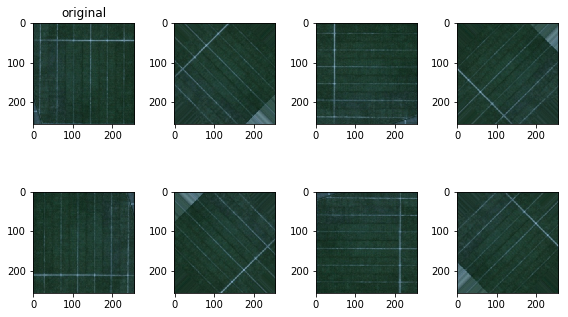

In [29]:
plt.figure(figsize=(8,5))
ax = plt.subplot(2,4,1)
ax.imshow(cv2.imread(oilimages[0]))
ax.set_title('original')

rot_filenames = gen_rot(oilimages[0])
for i, filename in enumerate(rot_filenames):
    ax = plt.subplot(2,4,i+2)
    ax.imshow(cv2.imread(filename))

plt.tight_layout()

Create another function `gen_stretch` that generate 3 stretch images in either the x and y directions, and both. 

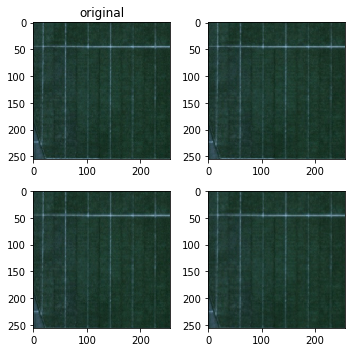

In [42]:
plt.figure(figsize=(5,5))
ax = plt.subplot(2,2,1)
ax.imshow(cv2.imread(oilimages[0]))
ax.set_title('original')

stre_filenames = gen_stretch(oilimages[0])
for i, filename in enumerate(stre_filenames):
    ax = plt.subplot(2,2,i+2)
    ax.imshow(cv2.imread(filename))

plt.tight_layout()

After checking that all the functions do what I intended. I apply it the rotation and stretch on all images.

In [73]:
rot_stre_files = []
for oilimage in oilimages: 
    rot_filenames = gen_rot(oilimage)
    stre_filenames = gen_stretch(oilimage)
    rot_stre_files  =  rot_stre_files + rot_filenames + stre_filenames

Pick some of the generated images to blur and the other half to change lighting.

In [84]:
to_blur = np.random.choice(rot_stre_files, int(len(rot_stre_files)*0.5), replace=False)
len(to_blur)/2

1680.0

In [85]:
for filename in to_blur[:1680]:
    img = cv2.imread(filename)
    lightimg = lighting(img)
    savename = filename.replace('.jpg','light.jpg')
    cv2.imwrite(savename, lightimg)
    
for filename in to_blur[1680:]:
    img = cv2.imread(filename)
    blurimg = blur(img)
    savename = filename.replace('.jpg','blur.jpg')
    cv2.imwrite(savename, blurimg)

Append these files into the a labeled dataframe for NN to train on

In [87]:
aug_files = np.random.permutation(glob('train_add/*.jpg'))
len(aug_files)

12295

In [90]:
df.head()

,image_id,has_oilpalm
0,train_images/img_000002017.jpg,0
1,train_images/img_000012017.jpg,0
2,train_images/img_000022017.jpg,0
3,train_images/img_000072017.jpg,0
4,train_images/img_000082017.jpg,0


In [92]:
aug_files = aug_files[:8000]
label = np.ones(len(aug_files), dtype=np.int8)
df_add = pd.DataFrame({'image_id':aug_files, 'has_oilpalm':label})

In [95]:
df_new = pd.concat([df,df_add], ignore_index=True)
len(df_new), df_new.tail()

(21720,                                      image_id  has_oilpalm
 21715   train_add\img_003182018stre01blur.jpg            1
 21716       train_add\img_090082018rot225.jpg            1
 21717  train_add\img_054882018stre11light.jpg            1
 21718  train_add\img_101502017stre01light.jpg            1
 21719       train_add\img_009282017rot180.jpg            1)

In [97]:
df_new.to_csv('train_val_augment.csv',index=False)

Below are the augmented functions.

In [4]:
def gen_rot(filename, folder='train_add'):
    '''generate 8 rotated image, and safe them
    
    return a list of rotated image filenames
    '''
    img = cv2.imread(filename)
    rot_filenames = []
    for i in range(1,8):
        roimg = rotate_cv(img,i*45)
        savename =  filename.replace('train_has_oil', folder)
        savename = savename.replace('.jpg','rot'+str(i*45)+'.jpg')
        cv2.imwrite(savename, roimg)
        rot_filenames.append(savename)  
     
    return rot_filenames

In [40]:
def gen_stretch(filename, folder='train_add'):
    '''generate 3 zoom images from the imput image and saved them
    return a list of save filenames'''
    img = cv2.imread(filename)
    stre_filenames = []
    combo = [(0.01, 0), (0, 0.01), (0.01, 0.01)]
    for sr, sc in combo:
        stre_img = stretch_cv(img,sr,sc)
        savename =  filename.replace('train_has_oil',folder)
        savename = savename.replace('.jpg','stre'+str(sr)[-1]+str(sc)[-1]+'.jpg')
        cv2.imwrite(savename, stre_img)
        stre_filenames.append(savename) 
    return stre_filenames

In [6]:
def rotate_cv(im, deg, mode=cv2.BORDER_REPLICATE, interpolation=cv2.INTER_AREA):
    """ Rotate an image by deg degrees

    Arguments:
        deg (float): degree to rotate.
    """
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c//2,r//2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [7]:
def lighting(im, b=0.05, c=0.05):
    """ Adjust image balance and contrast """
    if b==0 and c==1: return im
    c = c+1
    b = b+1
    mu = np.average(im)
    return np.clip((im)*c+mu*b, 0, 255).astype(np.int)

In [8]:
def stretch_cv(x,sr,sc,interpolation=cv2.INTER_AREA):
    """ Stretches image x horizontally by sr+1, and vertically by sc+1 while retaining the original image size and proportion. """
    if sr==0 and sc==0: return x
    r,c,*_ = x.shape
    x = cv2.resize(x, None, fx=sr+1, fy=sc+1, interpolation=interpolation)
    nr,nc,*_ = x.shape
    cr = (nr-r)//2; cc = (nc-c)//2
    return x[cr:r+cr, cc:c+cc]

In [9]:
def blur(img):
    kernel_size = np.random.choice([5, 7, 9])
    return cv2.GaussianBlur(img, ksize=(kernel_size,kernel_size), sigmaX=0) 

In summary, I create 12295 augmented image and randomly append 8000 of them for NN to train.